In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CIS680/HW4/Part(b) BoxHead

/content/drive/MyDrive/CIS680/HW4/Part(b) BoxHead


In [1]:
import torch
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from dataset import *
from utils import *
from BoxHead import *
from torchvision import transforms, ops
from pretrained_models import pretrained_models_680
from torchvision.models.detection.image_list import ImageList
from tqdm import tqdm

Build dataset and dataloader for both training and validation

In [ ]:
## Build the dataset ##
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
dataset = BuildDataset(paths)
# Split the whole dataset into 80% training and 20% validation
full_size = len(dataset)
train_size = int(full_size * 0.8)
val_size = full_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

## Build dataloader from training and validation dataset ##
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
train_loader = train_build_loader.loader()
val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = val_build_loader.loader()

## Pretrained backbone model ##
pretrained_path = 'data/checkpoint680.pth'
backbone, rpn = pretrained_models_680(pretrained_path)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Training

In [ ]:
# Initialize model
boxHead = BoxHead().cuda()
# Define optimizer
optimizer = torch.optim.Adam(boxHead.parameters(), lr=1e-3)
# Define running epoches and batch size
epochs = 40
keep_topK = 200
# Loss list
train_loss = []
cls_loss = []
reg_loss = []
val_loss = []

In [ ]:
for epoch in range(epochs):
    ## Training ##
    boxHead.train()
    train_epoch_loss = 0
    cls_epoch_loss = 0
    reg_epoch_loss = 0
    # Iterate through all batches in train loader
    for iter, batch in enumerate(tqdm(train_loader), 0):
        # 1. Extract current batch
        images = batch['images'].cuda()
        labels = batch['labels']
        boxes = batch['bbox']
        optimizer.zero_grad()
        # 2. Get proposals and feature pyramid from pretrained FPN and RPN
        backout = backbone(images)
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)
        proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
        fpn_feat_list = list(backout.values()) # list:len(FPN) {(bz,256,H_feat,W_feat)}
        # 3. Forward of boxHead model
        feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list, proposals)
        pred_class, pred_coord = boxHead.forward(feature_vectors)
        # 4. Get corresponding GT cls and reg to compute loss
        gt_labels, gt_reg = boxHead.create_ground_truth(proposals, labels, boxes)
        train_batch_loss, loss_cls, loss_reg = boxHead.compute_loss(pred_class, pred_coord, gt_labels, gt_reg)
        # 5. Keep record of total loss, cls loss and reg loss
        train_epoch_loss += train_batch_loss.item()
        cls_epoch_loss += loss_cls.item()
        reg_epoch_loss += loss_reg.item()
        # 6. Optimizer
        train_batch_loss.backward()
        optimizer.step()
    # Append training loss 
    train_loss.append(train_epoch_loss / len(train_loader))
    cls_loss.append(cls_epoch_loss / len(train_loader))
    reg_loss.append(reg_epoch_loss / len(train_loader))
    
    ## Validation ##
    boxHead.eval()
    val_epoch_loss = 0
    # Iterate through all batches in train loader
    for iter, batch in enumerate(tqdm(val_loader), 0):
        # 1. Extract current batch
        images = batch['images'].cuda()
        labels = batch['labels']
        boxes = batch['bbox']
        with torch.no_grad():
            # 2. Get proposals and feature pyramid from pretrained FPN and RPN
            backout = backbone(images)
            im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
            rpnout = rpn(im_lis, backout)
            proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
            fpn_feat_list = list(backout.values()) # list:len(FPN) {(bz,256,H_feat,W_feat)}
            # 3. Forward of boxHead model
            feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list, proposals)
            pred_class, pred_coord = boxHead.forward(feature_vectors)
            # 4. Get corresponding GT cls and reg to compute loss
            gt_labels, gt_reg = boxHead.create_ground_truth(proposals, labels, boxes)
            val_batch_loss, _, _ = boxHead.compute_loss(pred_class, pred_coord, gt_labels, gt_reg)
            # 5. Keep record of total loss, cls loss and reg loss
            val_epoch_loss += val_batch_loss.item()
    # Append validation loss
    val_loss.append(val_epoch_loss / len(val_loader))

    ## Print current epoch info ##
    print(f"Epoch: {epoch}\t Training loss: {train_epoch_loss / len(train_loader)}\t Validation loss: {val_epoch_loss / len(val_loader)}")

    ## Save model checkpoint ##
    curr_val_loss = val_epoch_loss / len(val_loader)
    path = f"result/epoch={epoch}-val={curr_val_loss:.3f}.pth"
    torch.save(boxHead.state_dict(), path)

### Loss plot

Text(0.5, 1.0, 'Regression training loss')

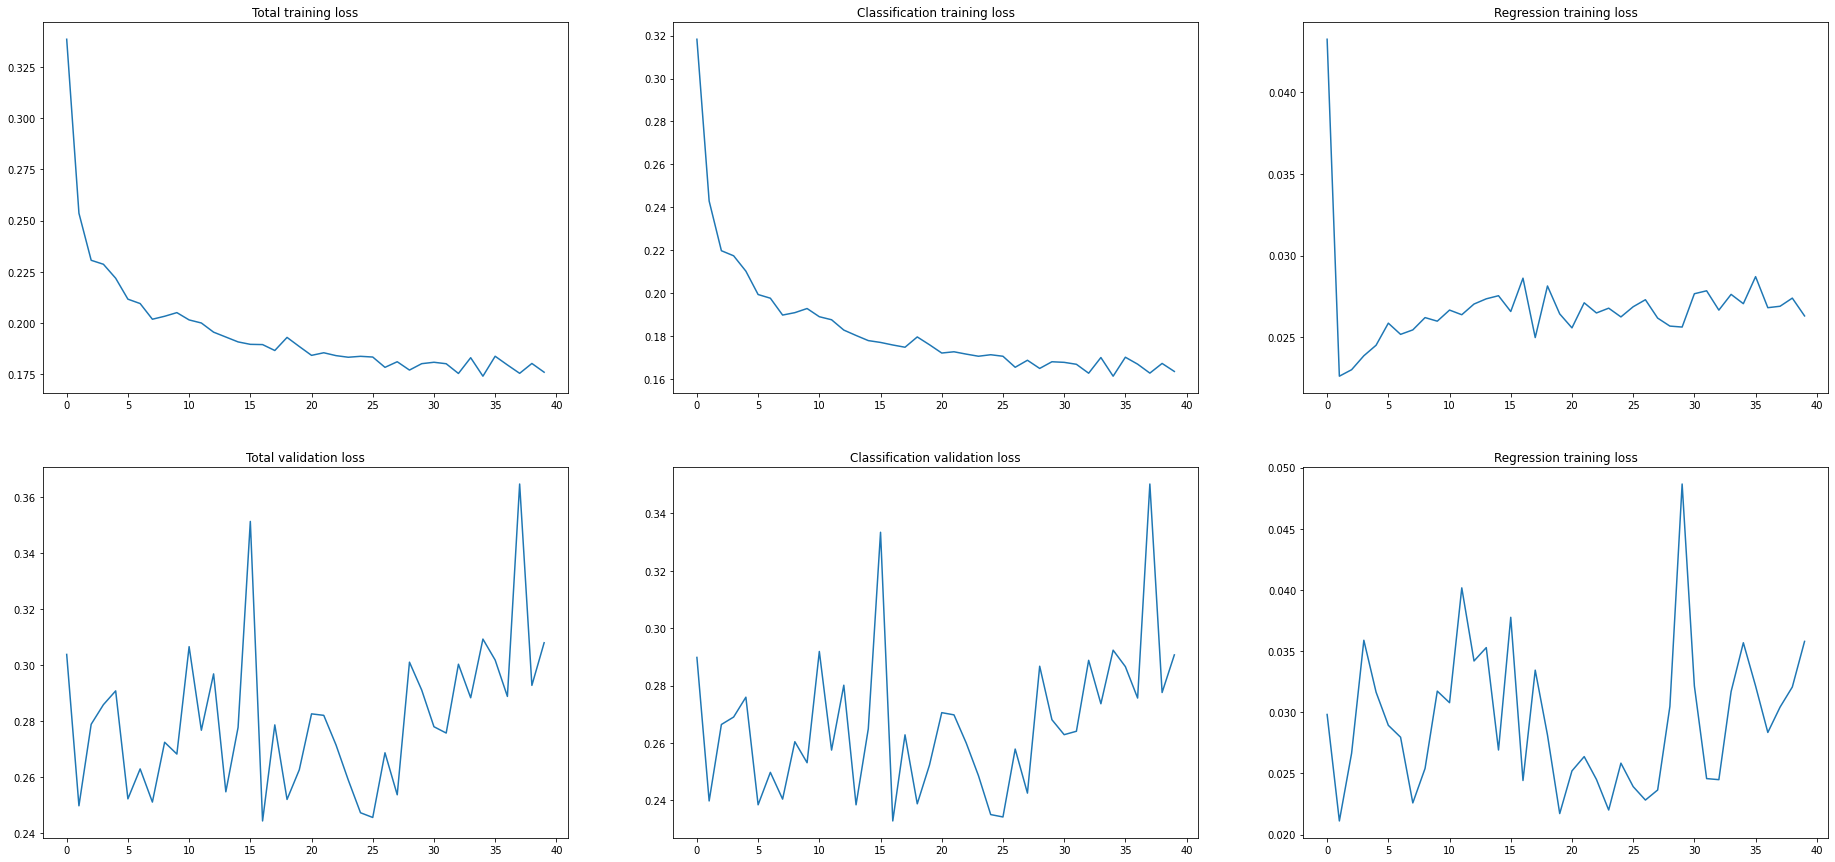

In [2]:
np.save("train_loss.npy", train_loss)
np.save("cls_loss.npy", cls_loss)
np.save("reg_loss.npy", reg_loss)
np.save("val_loss.npy", val_loss)

train_loss = np.load("result/train_loss.npy")
train_cls_loss = np.load("result/cls_loss.npy")
train_reg_loss = np.load("result/reg_loss.npy")
val_loss = np.load("result/val_loss.npy")
val_cls_loss = np.load("result/val_cls_loss.npy")
val_reg_loss = np.load("result/val_reg_loss.npy")
fig, ax = plt.subplots(2,3,figsize=(32,15))
ax[0,0].plot(train_loss)
ax[0,0].set_title('Total training loss')
ax[0,1].plot(train_cls_loss)
ax[0,1].set_title('Classification training loss')
ax[0,2].plot(train_reg_loss)
ax[0,2].set_title('Regression training loss')
ax[1,0].plot(val_loss)
ax[1,0].set_title('Total validation loss')
ax[1,1].plot(val_cls_loss)
ax[1,1].set_title('Classification validation loss')
ax[1,2].plot(val_reg_loss)
ax[1,2].set_title('Regression training loss')